# Classifying CIFAR100 using a ResNet model in PyTorch

Steps we'll follow:
1. Download the dataset from Kaggle
2. Load the dataset using Torchvision
3. Use a pretrained ResNet34 model
4. Set up a training loop with GPU support
5. Train the model & tune hyperparameters
6. Evalute the model and make sample predictions

## Download the Dataset from Kaggle

In [2]:
!pip install opendatasets jovian --upgrade --quiet

In [3]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/aymenboulila2/cifar100'
od.download(dataset_url)

  4%|▎         | 5.00M/140M [00:00<00:03, 43.7MB/s]

100%|██████████| 140M/140M [00:01<00:00, 96.8MB/s]


In [4]:
data_dir = 'cifar100/CIFAR100'

## Load the Dataset using Torchvision

In [5]:
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [6]:
means, stds = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225] # imagenet stats

train_ds = ImageFolder(data_dir + '/TRAIN', T.Compose([T.ToTensor(), T.Normalize(means, stds, inplace=True)]))
valid_ds = ImageFolder(data_dir + '/VALID', T.Compose([T.ToTensor(), T.Normalize(means, stds, inplace=True)])) 
test_ds = ImageFolder(data_dir + '/TEST', T.Compose([T.ToTensor(), T.Normalize(means, stds, inplace=True)])) 

In [7]:
from torch.utils.data import DataLoader

In [8]:
batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size)
test_dl = DataLoader(test_ds, batch_size)

In [9]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, means, stds)
        ax.imshow(make_grid(denorm_images[:100], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

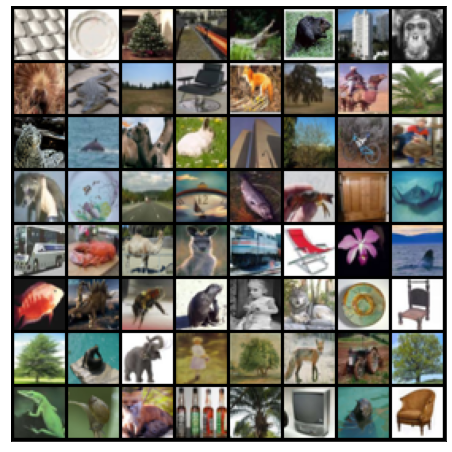

In [10]:
show_batch(train_dl)

## Use a pretrained ResNet34 model

In [11]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))


In [12]:
from torchvision import models

class CIFAR100Model(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

## GPU Utilities and Training Loop



In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [14]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [20]:
model = CIFAR100Model(len(train_ds.classes), pretrained=True)
to_device(model, device);

## Training the model

In [21]:
## Training the model

In [23]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.00905652903020382, 'val_loss': 5.092417240142822}]

In [24]:
history += fit(5, 1e-3, model, train_dl, valid_dl)


Epoch [0], train_loss: 4.3426, val_loss: 3.9119, val_acc: 0.1479



Epoch [1], train_loss: 3.5307, val_loss: 3.2139, val_acc: 0.2520



Epoch [2], train_loss: 2.9837, val_loss: 2.8244, val_acc: 0.3151



Epoch [3], train_loss: 2.6499, val_loss: 2.5833, val_acc: 0.3528



Epoch [4], train_loss: 2.4088, val_loss: 2.4269, val_acc: 0.3761


In [25]:
history += fit(10, 2e-3, model, train_dl, valid_dl)


Epoch [0], train_loss: 2.2144, val_loss: 2.2500, val_acc: 0.4100



Epoch [1], train_loss: 1.9793, val_loss: 2.1299, val_acc: 0.4350



Epoch [2], train_loss: 1.7870, val_loss: 2.0494, val_acc: 0.4544



Epoch [3], train_loss: 1.6240, val_loss: 2.0159, val_acc: 0.4613



Epoch [4], train_loss: 1.4835, val_loss: 1.9825, val_acc: 0.4716



Epoch [5], train_loss: 1.3519, val_loss: 1.9661, val_acc: 0.4788



Epoch [6], train_loss: 1.2340, val_loss: 1.9557, val_acc: 0.4808



Epoch [7], train_loss: 1.1220, val_loss: 1.9388, val_acc: 0.4926



Epoch [8], train_loss: 1.0224, val_loss: 1.9395, val_acc: 0.4912



Epoch [9], train_loss: 0.9191, val_loss: 1.9655, val_acc: 0.4895


In [26]:
history += fit(10, 1e-3, model, train_dl, valid_dl)


Epoch [0], train_loss: 0.7986, val_loss: 1.9571, val_acc: 0.4951



Epoch [1], train_loss: 0.7539, val_loss: 1.9704, val_acc: 0.4982



Epoch [2], train_loss: 0.6982, val_loss: 1.9744, val_acc: 0.4948



Epoch [3], train_loss: 0.6628, val_loss: 1.9904, val_acc: 0.4951



Epoch [4], train_loss: 0.6134, val_loss: 2.0077, val_acc: 0.4974



Epoch [5], train_loss: 0.5747, val_loss: 2.0085, val_acc: 0.4997



Epoch [6], train_loss: 0.5405, val_loss: 2.0250, val_acc: 0.5023



Epoch [7], train_loss: 0.5044, val_loss: 2.0356, val_acc: 0.5011



Epoch [8], train_loss: 0.4761, val_loss: 2.0638, val_acc: 0.4987



Epoch [9], train_loss: 0.4439, val_loss: 2.0717, val_acc: 0.4976


In [27]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

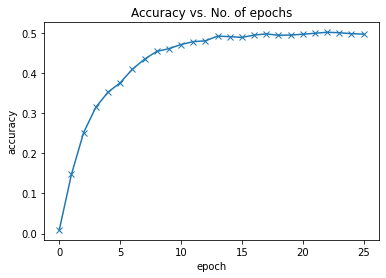

In [28]:
plot_accuracies(history)

In [29]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

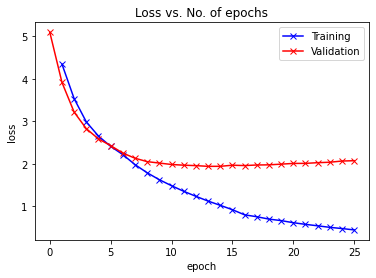

In [30]:
plot_losses(history)

## Testing with Individual Images

In [36]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return test_ds.classes[preds[0].item()]

In [48]:
def predict_and_show(idx):
    img, label = test_ds[idx]
    plt.imshow(denormalize(img, means, stds).squeeze(0).permute(1, 2, 0))
    print('Label:', test_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: apple , Predicted: apple


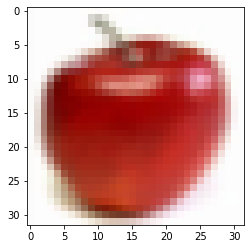

In [49]:
predict_and_show(0)

Label: bowl , Predicted: camel


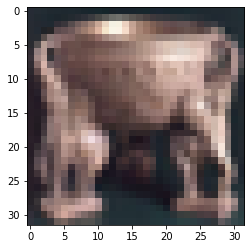

In [50]:
predict_and_show(1002)

Label: plate , Predicted: plate


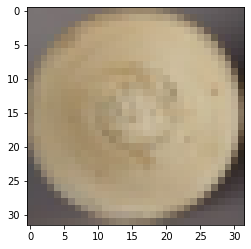

In [51]:
predict_and_show(6153)

In [53]:
result = evaluate(model, test_dl)
result

{'val_acc': 0.5140326619148254, 'val_loss': 1.9930150508880615}

In [54]:
torch.save(model.state_dict(), 'cifar100-resnet.pth')

In [ ]:
jovian.commit(project='cifar100-pytorch-resnet34', outputs=['cifar10-resnet.pth'])

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: 